# VQE FOR FINDING THE LOWEST EIGEN VALUE

$$\ \textit{We're given the hamiltonian matrix H = } \begin{pmatrix}0 & 0 & 0 & 0\\
0 & -1 & 1 & 0\\0 & 1 & -1 & 0\\0 & 0 & 0 & 0\end{pmatrix}$$

##  **VQE SIMULATED WITHOUT ANY NOISE**

### Finding out the lowest eigen value by first finding out all the eigen values

In [1]:
%matplotlib inline
import numpy as np
from numpy import pi, linspace
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from scipy import optimize

In [2]:
# The given Hamiltonian matrix
H = np.mat("0 0 0 0; 0 -1 1 0; 0 1 -1 0; 0 0 0 0")
# Printing out the eigenvalues and lowest one of them
print("The eigenvalues of the Hamiltonian is: ", np.linalg.eigvals(H))
print('The exact ground state energy is: ', min(np.linalg.eigvals(H)))

The eigenvalues of the Hamiltonian is:  [ 0. -2.  0.  0.]
The exact ground state energy is:  -2.0


#### Now we know that the lowest eigenvalue is -2.0

### Before we do that, we need to express the given Hamiltonian matrix in a quantum circuit. Doing this will enable Quantum Computer to measure the expectation values.    This will be done by decomposing the hamiltonian in terms of the linear combination of the tensor products of Pauli operators i.e.
$$H = \alpha*I \otimes I + \beta*X \otimes X + \gamma*Y \otimes Y + \theta*Z \otimes Z $$  

#### Now we have to solve the the equation Ax = b, to find the values of $$\alpha , \beta, \gamma \textit{ and } \theta$$
$$ \textit{Here matrices A, x and b are } \begin{pmatrix} 1 & 0 & 1 & 0\\ 0 & 1 & 0 & -1\\ 1 & 0 & -1 & 0\\ 0 & 1 & 0 & 1 \end{pmatrix}, \begin{pmatrix} \alpha\\ \beta\\ \theta\\ \gamma\end{pmatrix} \textit{ and } \begin{pmatrix} 0 \\ 0 \\ -1 \\ 1 \end{pmatrix} \textit{ respectively.}$$

In [3]:
A = np.array([[1,0,1,0],[0,1,0,-1],[1,0,-1,0],[0,1,0,1]])
b = np.array([0,0,-1,1])
x = np.linalg.solve(A,b)
alpha, beta, gamma, theta = x[0], x[1], x[3], x[2]
print(f"Therefore the Hamiltonian H = {alpha}*II + {beta}*XX + {gamma}*YY + {theta}*ZZ ")

Therefore the Hamiltonian H = -0.5*II + 0.5*XX + 0.5*YY + 0.5*ZZ 


### Applying Variational method to get the minimum energy which would be our eigen value that has the lowest eigen value.

In [4]:
def ansatz(circuit, parameter):
    qreg = circuit.qregs[0]
    circuit.h(qreg[0])
    circuit.rz(parameter, qreg[0])
    circuit.cx(qreg[0], qreg[1])
    circuit.x(qreg[1])
    return circuit

### Now we want to measure them therefore there is a need to convert them into a computational basis(Z basis). 
$$\textit{We know that X basis }{|+ \rangle \textit{,} | - \rangle} \textit{ can be measured into Z basis by applying the Hadamard gate and}$$
$$ \textit{Similarly Y basis } {|\circlearrowleft\rangle, |\circlearrowright\rangle}\textit{ can be measured into Z basis by first applying S-adjoint}$$
$$\textit{ gate and then Hadamard gate. Here therefore the two gates to be applied for X and Y bases are } $$
$$ \tfrac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \textit{ and } \begin{pmatrix}1 & -i\\1 & -i\end{pmatrix} \textit{ respectively.} $$

In [5]:
# So we'll create a function which will help us to measure in all three basis 
def measurement(measured, parameter):
    # Applying ansatz for the circuit
    qreg = QuantumRegister(2)
    creg = ClassicalRegister(2)
    circuit = QuantumCircuit(qreg, creg)
    circuit = ansatz(circuit, parameter)
    
    # Now checking different bases and if they're not computational basis then applying necessary gates.
    # Just measuring it if it's ZZ     
    if measured == 'ZZ':
        circuit.measure(qreg[0], creg[0])
        circuit.measure(qreg[1], creg[1]) 
    elif measured == 'XX':
        circuit.barrier(qreg[0],qreg[1])
        circuit.u2(0, pi, qreg[0])
        circuit.u2(0, pi, qreg[1])
        circuit.measure(qreg[0], creg[0])
        circuit.measure(qreg[1], creg[1])
    elif measured == 'YY':
        circuit.barrier(qreg[0],qreg[1])
        circuit.u2(0, pi/2, qreg[0])
        circuit.u2(0, pi/2, qreg[1])
        circuit.measure(qreg[0], creg[0])
        circuit.measure(qreg[1], creg[1])
    return circuit

### We know that the expectation value can be calculated in the Z basis through
$$\tfrac{1}{N}(N_{00} + N_{11} - N_{01} - N_{10}) $$
$$\textit{Here the }N_{01}, N_{10}\textit{ are multiplied with -1 but }N_{00}, N_{11}\textit{ are multiplied with 1 as}$$
$$\langle 01|Z \otimes Z|01 \rangle = \langle 10|Z \otimes Z|10 \rangle = -1$$
$$and$$
$$ \langle 00|Z \otimes Z|00 \rangle = \langle 11|Z \otimes Z|11 \rangle = 1$$

In [6]:
# Now we need to calculate the expectation values
def exp_value(measured, parameter):
    if measured == 'II':
        return 1
    if measured == 'XX':
        circuit = measurement('XX', parameter)
    elif measured == 'YY':
        circuit = measurement('YY', parameter)
    elif measured == 'ZZ':
        circuit = measurement('ZZ', parameter)
    
    backend = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = backend).result()
    counts = result.get_counts()
    # When counts of 00, 11, 01 or 10 are zero so we need to tackle that exception
    counts_00, counts_01, counts_10, counts_11 = [0]*4
    for x in counts:
        if x == '00':
            counts_00 = counts[x]
        if x == '01':
            counts_01 = counts[x]
        if x == '10':
            counts_10 = counts[x]
        if x == '11':
            counts_11 = counts[x]
            
    expec_value = (counts_00 + counts_11 - counts_01 - counts_10)/1024
        
    return expec_value

In [7]:
# Calculating sum of products of coefficients and their respective expectation values to calculate 
# summation of expectation value  
def summation(parameter):
    exp_value_I_I = exp_value('II', parameter) * alpha
    exp_value_X_X = exp_value('XX', parameter) * beta
    exp_value_Y_Y = exp_value('YY', parameter) * gamma
    exp_value_Z_Z = exp_value('ZZ', parameter) * theta
    
    sum_exp = exp_value_I_I + exp_value_X_X + exp_value_Y_Y + exp_value_Z_Z
    return sum_exp

In [8]:
parameter = 1 #initialize an arbitrary angle

# applying minimize function with method as cobyla and tolerance equal to 1e-4
sum_result = optimize.minimize(summation, parameter, method="COBYLA", tol=1e-4)
# printing the lowest evalue which we found before
print('The exact ground state energy is: -2')
print(f'The estimated ground state energy from VQE algorithm is: {sum_result.fun}')
# finding the best parameter which minimiezes the expectation value
print(f"\nThe optimal parameter is : {sum_result.x} ")

The exact ground state energy is: -2
The estimated ground state energy from VQE algorithm is: -2.0

The optimal parameter is : 3.125 


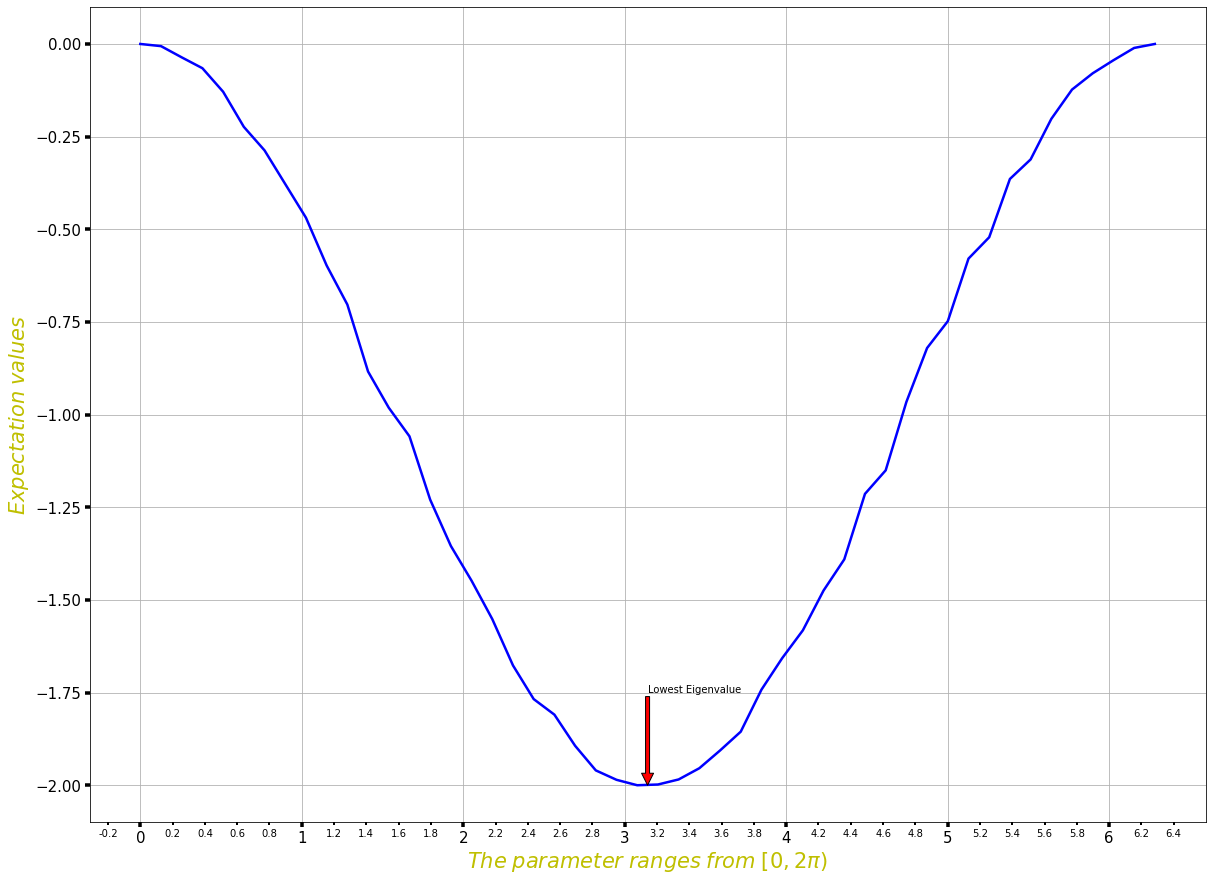

In [9]:
# List of parameters ranging from 0 to 2*pi
gradients = np.linspace(0, 2 * pi, 50)
minimal = []
# Iterating over parameters to get their respective expectation value
for parameter in gradients:
    minimal_value = summation(parameter)
    minimal.append(minimal_value) 
# Plotting a graph to visualize expectation values and parameters.   
figure = plt.figure(figsize=(20,15))
axes = figure.add_subplot()
axes.plot(gradients, minimal, linewidth=2.5, color='blue')
# The best parameter is pi which one would expect
axes.annotate('Lowest Eigenvalue', xytext=(pi, -1.75), xy=(pi, -2),
             arrowprops=dict(facecolor='red'))
axes.xaxis.set_minor_locator(AutoMinorLocator()) 
axes.xaxis.set_minor_formatter(FuncFormatter(FormatStrFormatter('%.1f'))) 
# Controlling the minor, major graduation and then graduation for both axes
axes.tick_params(which='minor', length=3, color='black')
axes.tick_params(which='major', length=5) 
axes.tick_params(which='both', width=2) 
axes.tick_params(labelcolor='black', labelsize=15, width=3.5)
plt.ylabel(r'$Expectation \; values$', {'fontsize': 21, 'color': 'y'})
plt.xlabel(r'$The\; parameter\; ranges\; from\; [0,2\pi)$',  {'fontsize': 21, 'color': 'y'})
plt.grid()
plt.show()


In [10]:
# The best angle which given by the optimizer would be utilized through interpolation.
interpol = np.interp( sum_result.x, gradients, minimal)
print("The Lowest Eigenvalue obtained is: ", interpol)

The Lowest Eigenvalue obtained is:  -1.999276170584089
